## Головоломка Джона

Решение паззла. Размещение хитровывернутых двумерных фигур по полю.

![Головоломка в разобранном виде](img/puzzle-I.png)
![головоломка в собранном виде](img/puzzle-II.png)


### Предистория

Написал мне как-то друг в телеграм.  Даже не столько написал, сколько скинул две фотографии головоломки, которую ему, судя по всему, подарили на день рождения.

Намекая, что хорошо бы такую задачу решить, не перекладывая фигурки на доске, а алгоритмически. 
Зная бросающего вызов, можно было предположить, что его решение существует, готово, и весьма близко к идеальному.
Что, он, кстати, при встрече и продемонстрировал - у него перебор всех вариантов за все даты за считанные секунды проходит.

Для каждой даты решение не единственное, алгоритм, разумеется, должен выдавать все.

Поучаствовал. С превеликим удовольствием. Скажу честно, первый вариант был "штурмом в лоб" и работал практически вечность. Там время измерялась минутами, даже без рисования.
Так что пришлось вернуться к задаче и сделать по-человечески. 

В итоге я, как видите, даже не поленился привести в приличный вид и выложить. За алгоритм, в общем, не стыдно. 

Хотя можно и дальше улучшать (у некоторых симметрий есть лишние проверки), но существенной роли это не уже сыграет. 

In [1]:
import numpy as np
from datetime import datetime
from itertools import product, combinations, permutations
import matplotlib.pyplot as plt
import time

Создаем всякие константы. В том числе и дату, которую будем искать на головоломке.

In [2]:
FIELD_ID = 17
DATE_ID = 19
search_date = datetime.strptime("2014-09-10", '%Y-%m-%d')

Функции сопровождения

In [3]:
def fig2tuple(fig):
    return tuple(map(tuple, fig))

# Собираем симметрии фигуры
def get_fig_variants(fig):
  vars = [fig, np.flip(fig), np.flip(fig,1), np.flip(fig,0), fig.T, np.flip(fig.T, 1), np.flip(fig.T, 0), np.flip(fig.T)]
  return list(map(np.array, set(map(fig2tuple, vars))))

# Готовим дату, чтоб поставить на поле
def date_to_place(date):
    return (((date.month - 1) // 6, (date.month - 1) % 6), ((date.day - 1) // 7 + 2, (date.day - 1) % 7))

# Ставим фигуру на поле
def place_figure(field, fig, x, y):
    part = field[x:fig.shape[0] + x, y:fig.shape[1] + y]
    if np.sum(part & fig) == 0: #Если можно поставить
        field[x:fig.shape[0] + x,y:fig.shape[1] + y] += fig
        return True
    return False  

# Убираем фигуру с поля    
def remove_figure(field, fig, x, y):
    field[x:fig.shape[0] + x,y:fig.shape[1] + y] -= fig

Нарисуем результат.

In [4]:
def draw_field(tiles=[]):
    val2color = {0:'white',1:'#0000FF',3:'#4169E1',5:'#6495ED',7:'#87CEEB',9:'#ADD8E6',11:'#B0C4DE',13:'#E0FFFF',15:'0.75',17:'0.3',19:'#22ff22'}
    fig, axes = plt.subplots(1, 1, squeeze=False)      
    rows, cols = field.T.shape
    fld = np.flip(field,0)
    for r in range(rows):
        for c in range(cols):
            color = val2color[fld[r, c]]
            rect = plt.Rectangle((c, rows - r - 1), 1, 1, facecolor=color, edgecolor='black')
            axes[0, 0].add_patch(rect)
        axes[0, 0].set_xlim(0, cols)
        axes[0, 0].set_ylim(0, rows)
        axes[0, 0].invert_yaxis()
        axes[0, 0].xaxis.tick_top()
        axes[0, 0].set_xticks([])
        axes[0, 0].set_yticks([])
    
    # Показываем график
    plt.tight_layout()
    plt.show()

Ну и собственно готовим входные данные: поле и варианты фигур

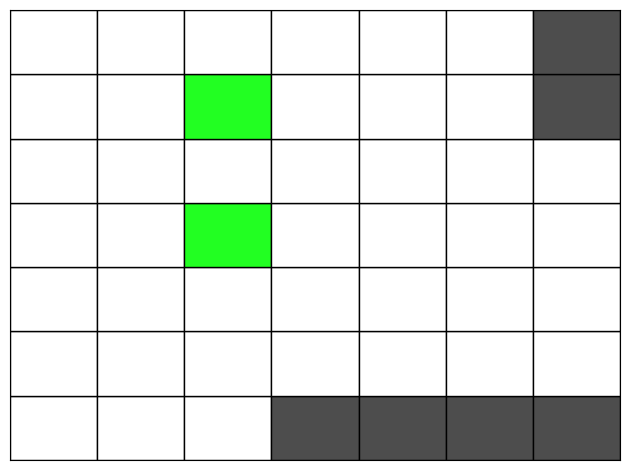

In [5]:
#Инициализируем массив фигур
figs = [
    get_fig_variants(np.array([[1,1,1], [1,1,1]])),
    get_fig_variants(np.array([[1,0,1], [1,1,1]]) * 3),
    get_fig_variants(np.array([[1,0,0], [1,0,0], [1,1,1]]) * 5),
    get_fig_variants(np.array([[0,1,1], [0,1,0], [1,1,0]]) * 7),
    get_fig_variants(np.array([[1,1,1,1], [1,0,0,0]]) * 9),
    get_fig_variants(np.array([[1,1,1,1], [0,1,0,0]]) * 11),
    get_fig_variants(np.array([[0,1,1,1], [1,1,0,0]]) * 13),
    get_fig_variants(np.array([[1,1,1], [0,1,1]]) * 15),
]

#Делаем поле для игры
def init_field():
    field = np.zeros((7,7), np.byte)
    field[0,6] = FIELD_ID
    field[1,6] = FIELD_ID
    for i in range(3,7):
        field[6,i] = FIELD_ID
    places = date_to_place(search_date)
    field[places[0]] = DATE_ID
    field[places[1]] = DATE_ID
    return field
field = init_field()
draw_field()

Пара функций уже для собственно работы алгоритма

In [6]:
#Пробегаемся по всем доступным фигурам
def iterate_figures(skip):
    for i, fig_list in enumerate(figs):
        if i not in skip:
            for j,fig in enumerate(fig_list):
                yield fig, i, j

fig_starts = np.array([0] * 64)
for fig,i,j in iterate_figures([]):
    fig_start = 0
    while fig[fig_start][0] == 0: #Не вычислять, запоминать
        fig_start += 1    
    fig_starts[i*8 + j] = fig_start

def first_empty_cell_in_col(field, column_id):
    for i in range(7):#Не находить каждый раз, давать.
        if field[i][column_id]==0:  
           return i                 
    return None
#Подбираем варианты как вставлять фигуру
def place_fig(field, fig, fig_start, column_id, i):
    if i == None:
        return
    if i-fig_start >=0 and fig.shape[0]+i-fig_start < 8 and column_id + fig.shape[1] < 8:
        if place_figure(field, fig, i-fig_start, column_id):
            yield
            remove_figure(field, fig, i-fig_start, column_id)



Поехали!

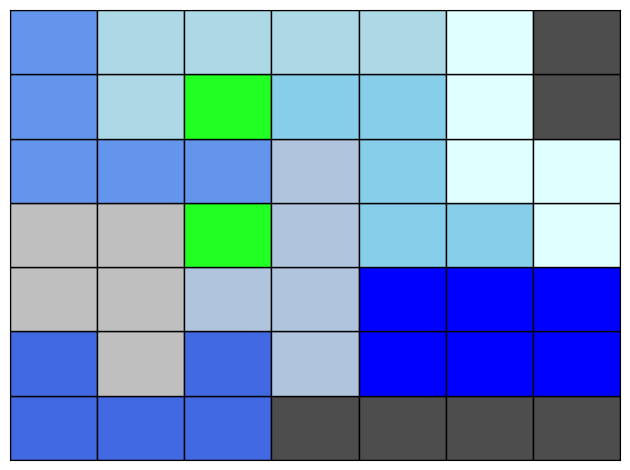

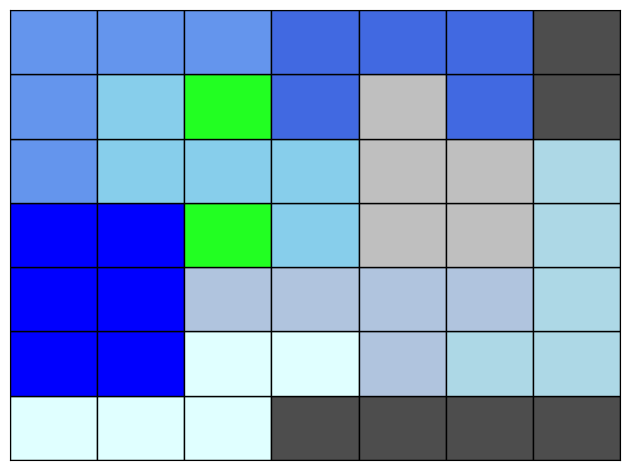

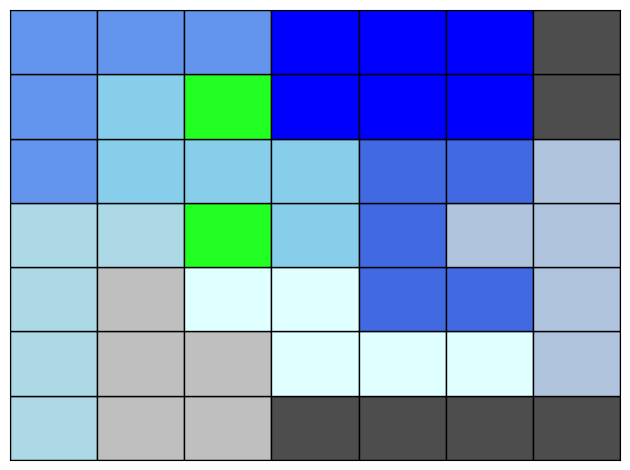

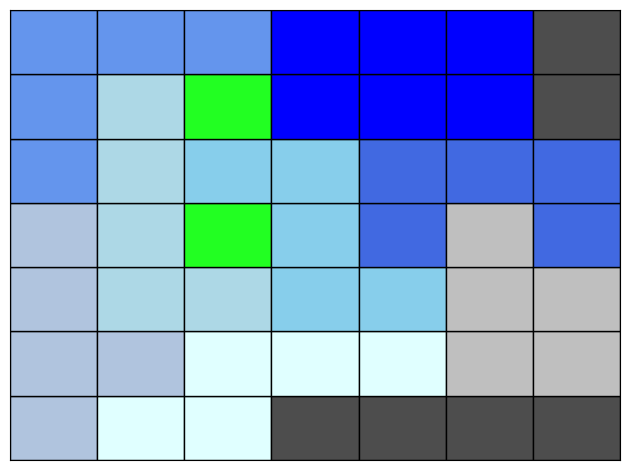

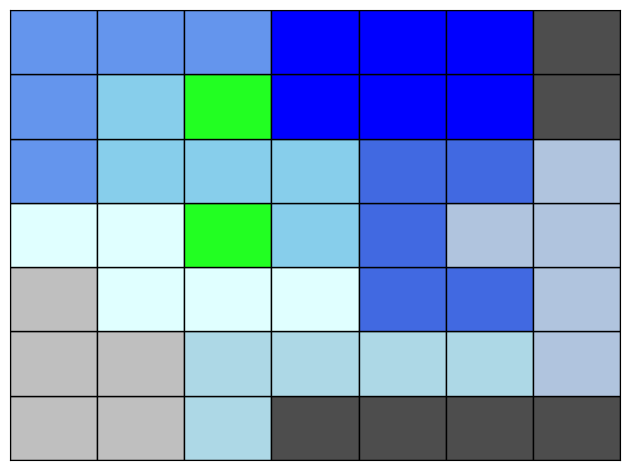

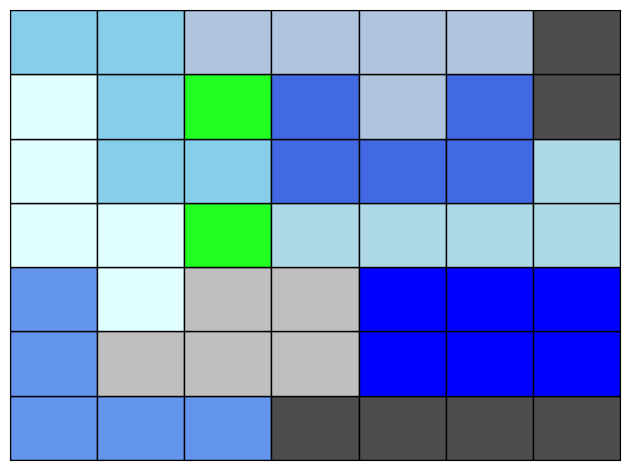

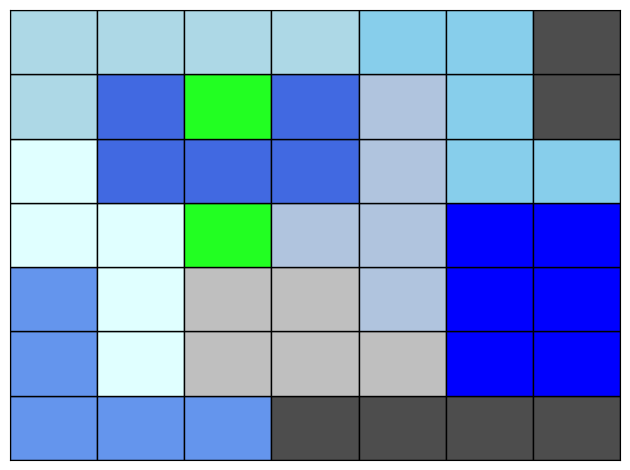

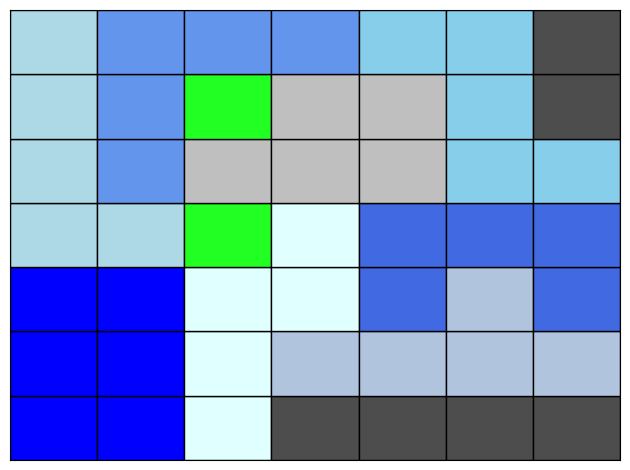

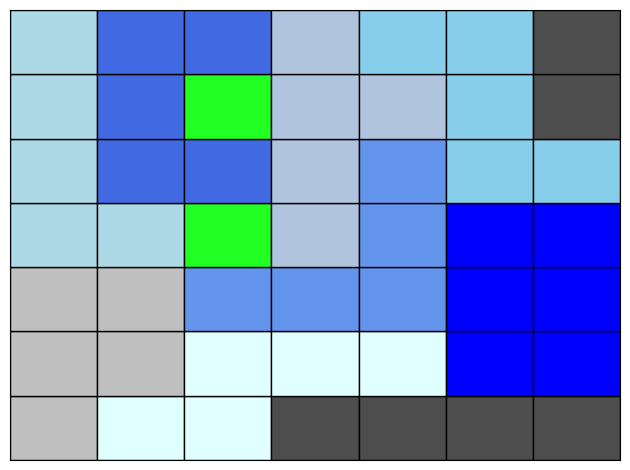

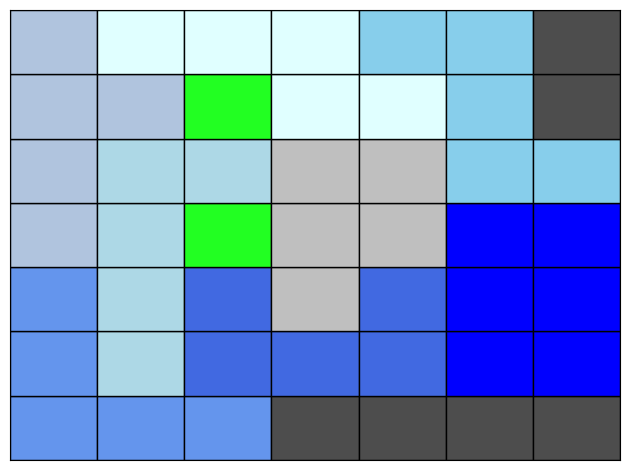

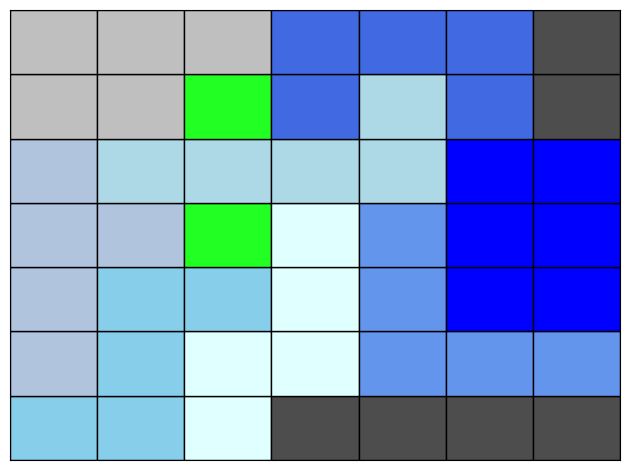

Время выполнения: 2.1770 секунд


In [7]:
def search(column_id=0, skip=[]):
    global field
    if len(skip) == 8:
        draw_field()
        return
    for fig, fig_type, i in iterate_figures(skip):
        col = first_empty_cell_in_col(field, column_id)
        for _ in place_fig(field, fig, fig_starts[fig_type * 8 + i], column_id, col):
            if (field[:,column_id] == 0).any():
                 search(column_id, skip + [fig_type])
            else:
                search(column_id+1, skip + [fig_type])
field = init_field()
start_time = time.time()
search()
end_time = time.time()
total_time = end_time - start_time
print(f"Время выполнения: {total_time:.4f} секунд")